In [ ]:
!pip install -q petals
!pip install -U sentence-transformers

In [2]:
import torch
from transformers import BloomTokenizerFast 
from petals import DistributedBloomForCausalLM
from sentence_transformers import SentenceTransformer
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
from tqdm import tqdm
import statistics
import requests
import json
import re
import os
import random
import time
random.seed(2)

# загружаем модель bloom-7b1-petals для генерации текста
MODEL_NAME = "bigscience/bloom-7b1-petals"
tokenizer = BloomTokenizerFast.from_pretrained(MODEL_NAME)
model = DistributedBloomForCausalLM.from_pretrained(MODEL_NAME)
model = model.cuda()

In [3]:
url_GSM8K = 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/train.jsonl'

# выгружаем размеченные данные из GSM8K
data_GSM8K = urllib.request.urlopen(url_GSM8K).read().decode("utf-8").splitlines()


In [4]:
# каждый prompt начинается с EXAMPLES_NUMBER одинаковых примеров вопрос-решение-ответ
# используем NUMBER_OF_TEST_PROBLEMS задач для сравнения greedy и self-sonsistency методов
# берем NUMBER_OF_SAMPLES сэмплов для ансамблированного CoT
EXAMPLES_NUMBER = 5
NUMBER_OF_TEST_PROBLEMS = 100
NUMBER_OF_SAMPLES = 15
PROMPTS = []
ANSWERS = []

# выбираем случайно индексы для примеров
example_index = [random.randint(1, len(data_GSM8K)) for _ in range(EXAMPLES_NUMBER)] 

examples_string = '' 
for i in example_index:
  examples_string += 'question: ' + json.loads(data_GSM8K[i])["question"] +\
                     '\nanswer: ' + json.loads(data_GSM8K[i])["answer"  ] + '.\n\n'

examples = re.sub(r"<<[\d\W]+>>", "",examples_string.replace("####", "The answer is"))

# подготавливаем список PROMPTS и список правильных решений-ответов ANSWERS
for i,problem in enumerate(data_GSM8K):
  if i not in example_index:
    PROMPTS.append((examples.replace("####", "The answer is") + '\nquestion: ' +\
                    json.loads(problem)["question"] + '\nanswer: ').replace("\n", ""))
    
    thoughts = json.loads(data_GSM8K[i])["answer"]
    ANSWERS.append([thoughts[thoughts.find('#### ') + len('#### '):], thoughts])

In [3]:
# генерируем ответ на prompt батчами по 50 токенов пока не встретим answer или не достигнем
# ограничения max_len токенов
def Responce(prompt, greedy=True, max_len=500):
  example_len = len(prompt)
  try:
    match_re = re.search(r"answer(.*?)\.", prompt[example_len:], re.IGNORECASE)
    while (not match_re) and (len(prompt) - example_len < max_len):
      outputs = model.generate(
          tokenizer(prompt, return_tensors="pt")["input_ids"].cuda(), 
          do_sample      = not greedy, 
          max_new_tokens = 50,
          )
      prompt   = tokenizer.decode(outputs[0])
      match_re = re.search(r"answer(.*?)\.", prompt[example_len:], re.IGNORECASE)
    return prompt[example_len:]

  except Exception as e: 
    print(e)
    time.sleep(10)
    return Responce(prompt, greedy=greedy, max_len=max_len)




In [ ]:
# для каждой задачи генерируем NUMBER_OF_SAMPLES сэмплов (not greedy) и записываем на гугл диск
drive.mount('/content/drive')

if not os.path.exists('/content/drive/MyDrive/Colab Notebooks'):
  os.makedirs('/content/drive/MyDrive/Colab Notebooks')

for i in tqdm(range(NUMBER_OF_TEST_PROBLEMS)):
  for _ in range(NUMBER_OF_SAMPLES):
    result = Responce(PROMPTS[i], greedy=False, max_len=500)
    with open(f'/content/drive/MyDrive/Colab Notebooks/ensemble_{i}_easy.txt', 'a') as f:
      f.write(result + '#\n\n')
      f.flush()

In [ ]:
# генерация greedy решений 
for i in tqdm(range(NUMBER_OF_TEST_PROBLEMS)):
  result = Responce(PROMPTS[i], greedy=True, max_len=500)
  with open(f'/content/drive/MyDrive/Colab Notebooks/greedy_easy.txt', 'a') as f:
    f.write(result + '#\n\n')
    f.flush()

In [6]:
# ищем в сгененированном решении ответ: сначала пробуем найти подстроку "answer _ ."
# если такую не встретили, ищем, когда в последний раз встретилось выражение "= число"
# в противном случае просто возьмём последнее сгенерированное число
def Answer_search(string):
    pattern  = r"answer[^.]*\s+([0-9]+)[^.]*\."
    match_re = re.search(pattern, string)
    if match_re:
      return int(match_re.group(1))

    pattern  = r"=(\s*\d+)\b"
    match_re = re.findall(pattern, string)
    if match_re:
      return int(match_re[-1])

    pattern  = r'\d+'
    match_re = re.findall(pattern, string)
    if match_re:
      return match_re[-1]
    
    return 'no answer'


In [7]:
# из текстовых файлов достаём рассуждения и ответы
with open(f'/content/greedy_easy.txt', 'r') as f:
  GREEDY_THOUGHTS = f.read().replace('\n', '').split("#")[:-1]

GREEDY_ANSWERS = [Answer_search(thought) for thought in GREEDY_THOUGHTS]


GENERATED_THOUGHTS = []
for i in range(NUMBER_OF_TEST_PROBLEMS):
  with open(f'/content/ensemble_{i}_easy.txt', 'r') as f:
    line = f.read().replace('\n', '')
    GENERATED_THOUGHTS.append(line.split("#")[:-1])

GENERATED_ANSWERS = []
for thought in GENERATED_THOUGHTS:
  GENERATED_ANSWERS.append([Answer_search(thought[i]) for i in range(len(thought))]) 


In [78]:
# проверим, сколько раз greedy даёт правильный ответ
sum([1 for i in range(NUMBER_OF_TEST_PROBLEMS) if GREEDY_ANSWERS[i] == int(ANSWERS[i][0])])

2

In [48]:
# для ансамблированного CoT вычислим значения, встречающиеся наиболее часто, его будем считать ответом
mode_of_answers = [statistics.mode(GENERATED_ANSWERS[i]) for i in range(NUMBER_OF_TEST_PROBLEMS)]

# узнаем, сколько раз ответ совпал с настоящим
sum([1 for i in range(NUMBER_OF_TEST_PROBLEMS) if mode_of_answers[i] == int(ANSWERS[i][0])])

1

In [49]:
# посчитаем, сколько раз правильный ответ в принципе был сгенерирован при ансамблированном CoT
sum([1 for i in range(NUMBER_OF_TEST_PROBLEMS) if int(ANSWERS[i][0]) in GENERATED_ANSWERS[i]])

13

In [58]:
# загружаем модель Sentence-BERT 
sen_to_vec = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# векторизуем настроящие и greedy решения с помощью SBERT
ANSWER_EMBEDDINGS = [sen_to_vec.encode(ANSWERS[i][1])  for i in range(NUMBER_OF_TEST_PROBLEMS)]
GREEDY_EMBEDDINGS = [sen_to_vec.encode(GREEDY_THOUGHTS[i])  for i in tqdm(range(NUMBER_OF_TEST_PROBLEMS))]

# для каждого решения из ансамблированного CoT найдём вектор и вычислим вектор средних 
# арифметических по каждой задаче
MEAN_EMBEDDINGS = []
for thoughts in tqdm(GENERATED_THOUGHTS):
  mean_vector_ensemble = np.mean([sen_to_vec.encode(thoughts[i]) for i in range(NUMBER_OF_SAMPLES)],axis=0)
  MEAN_EMBEDDINGS.append(mean_vector_ensemble)

# определим расстояние между вектором решения и эталонным решением
def Distances(embeddings):
  return [np.linalg.norm(embeddings[i] - ANSWER_EMBEDDINGS[i]) for i in range(NUMBER_OF_TEST_PROBLEMS)]



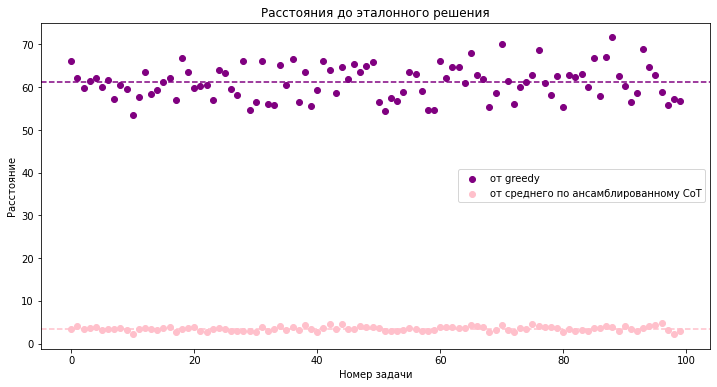

In [77]:
# визуализируем расстояния от greedy векторов до эталонных и от ансамблированных до 
# эталонных для каждой задачи
dists1 = Distances(GREEDY_EMBEDDINGS)
dists2 = Distances(MEAN_EMBEDDINGS)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

ax.scatter(range(len(dists1)), dists1, c='purple', label='от greedy')
ax.scatter(range(len(dists2)), dists2, c='pink',   label='от среднего по ансамблированному CoT')

ax.axhline(np.mean(dists1), c='purple', linestyle='--')
ax.axhline(np.mean(dists2), c='pink',   linestyle='--')

ax.set_xlabel('Номер задачи')
ax.set_ylabel('Расстояние')
ax.set_title('Расстояния до эталонного решения')

ax.legend()
plt.show()